In [1]:
import numpy as np
import xarray as xr

# --- Define constants used in the calculations ---
# Note: These are moved outside the main function so they are globally defined.
  # degrees C

def column_ild(sst, temp_col, depth_col, bottom_depth, ild_temp_offset = 0.5):
    """
    Calculates the Isothermal Layer Depth (ILD) for a single water column.
    
    This function is designed to be used with xarray.apply_ufunc.
    """
    # check if depth_col is positive
    if np.all(depth_col < 0):
        raise ValueError("Depth values must be positive")
    
    # check if increase monotonically
    if not np.all(np.diff(depth_col) > 0):
        raise ValueError("Depth values must increase monotonically")

    # temperature at ild level is surface/first layer temp minus the offset
    temp_ild_val = sst-ild_temp_offset

    # if all temp_col is NaN assign NaN
    if np.all(np.isnan(temp_col)) :
        return np.nan
    
    # If the entire column is warmer than the target temperature, ILD is the bottom depth.
    if np.nanmin(temp_col) > temp_ild_val:
        return bottom_depth
    else:
        # Find the first depth index where temperature is colder than the target
        try:
            # np.argmax finds the first 'True' value
            ind = np.argmax(temp_col < temp_ild_val)
            
            # If the first point is already colder, ILD is 0. Or if no change (ind=0)
            if ind == 0:
                # Check if the very first temp value is already below target
                if temp_col[0] < temp_ild_val:
                    return depth_col[0] # ILD is the shallowest depth
                # This case occurs if the value is not found, argmax returns 0.
                else: 
                    return np.nan

            # Get the temperature and depth values just above and at the crossing point
            temp_segment = temp_col[ind-1:ind+1]
            depth_segment = depth_col[ind-1:ind+1]
            
            # Linearly interpolate to find the exact depth of the target temperature
            # Note: np.interp expects x-coordinates (temp) to be increasing. We sort them.
            if temp_segment[0] > temp_segment[1]: # Normal case (temp decreases with depth)
                 return np.interp(temp_ild_val, temp_segment[::-1], depth_segment[::-1])
            else: # Inverted temperature
                 return np.interp(temp_ild_val, temp_segment, depth_segment)

        except (ValueError, IndexError):
            # Handle cases with all NaNs or other unexpected errors
            return np.nan

In [34]:
dict_data_info = {
    "region": "northeast_pacific",
    "subdomain": "full_domain",
    "experiment_type": "hindcast",
    "output_frequency": "monthly",
    "grid_type": "raw",
    "release": "r20250509",
    "data_source": "local",
    "local_top_dir": "/Projects/CEFI/regional_mom6/"
}
from mom6.mom6_module.mom6_read import AccessFiles
cefi_data_access = AccessFiles(**dict_data_info)

In [35]:
tos_path = cefi_data_access.get(variable='tos')[0]
thetao_path = cefi_data_access.get(variable='thetao')[0]
depth_path = cefi_data_access.get(variable='ocean_static')[0]


In [36]:
da_tos = xr.open_dataset(tos_path,chunks={'time': 1, 'yh': 50, 'xh': 50})['tos'].isel(time=slice(0,12))
da_thetao = xr.open_dataset(thetao_path,chunks={'time': 1, 'yh': 50, 'xh': 50, 'z_l': -1})['thetao'].isel(time=slice(0,12))
da_depth = xr.open_dataset(depth_path,chunks={'time': 1, 'yh': 50, 'xh': 50})['deptho']

In [37]:
da_tos

<xarray.DataArray 'tos' (time: 12, yh: 816, xh: 342)> Size: 13MB
dask.array<getitem, shape=(12, 816, 342), dtype=float32, chunksize=(1, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 96B 1993-01-16T12:00:00 ... 1993-12-16T12:...
  * xh       (xh) float64 3kB 229.1 229.2 229.3 229.3 ... 254.8 254.9 255.0
  * yh       (yh) float64 7kB 13.86 13.93 14.0 14.07 ... 59.5 59.51 59.52 59.52
Attributes:
    units:          degC
    long_name:      Sea Surface Temperature
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [38]:
print("--- Calculating Isothermal Layer Depth (ILD) ---")

# Apply the ILD helper function across all dimensions except 'z'
ild_05 = xr.apply_ufunc(
    column_ild,
    da_tos,
    da_thetao,
    da_thetao['z_l'],
    da_depth,
    kwargs={'ild_temp_offset': 0.5},
    input_core_dims=[[], ['z_l'], ['z_l'], []],  # Dimensions the function sees
    output_core_dims=[[]],  # The function returns a scalar
    exclude_dims=set(('z_l',)),  # Apply over all other dims
    vectorize=True, # To broadcast non-core dimensions automatically
    dask="parallelized",
    output_dtypes=[float]
)

--- Calculating Isothermal Layer Depth (ILD) ---


In [39]:
ild_05

<xarray.DataArray 'tos' (time: 12, yh: 816, xh: 342)> Size: 27MB
dask.array<transpose, shape=(12, 816, 342), dtype=float64, chunksize=(1, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 96B 1993-01-16T12:00:00 ... 1993-12-16T12:...
  * xh       (xh) float64 3kB 229.1 229.2 229.3 229.3 ... 254.8 254.9 255.0
  * yh       (yh) float64 7kB 13.86 13.93 14.0 14.07 ... 59.5 59.51 59.52 59.52
Attributes:
    units:          degC
    long_name:      Sea Surface Temperature
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [40]:
# more worker less threads due to GIL of the task involved
from dask.distributed import Client
client = Client(n_workers=80, threads_per_worker=1)
print(client.dashboard_link)
da_ild_05 = ild_05.compute()

http://127.0.0.1:46401/status


In [ ]:
ds_ild_05 = xr.Dataset()
ds_ild_05['ild_05'] = da_ild_05
ds_ild_05 = xr.merge([ds_ild_05, xr.open_dataset(depth_path)])
ds_ild_05 = ds_ild_05.set_coords(['geolon', 'geolat'])
# due to missing value in the coordinate
ds_ild_05['geolon'] = ds_ild_05['geolon'].where(ds_ild_05['geolon'].notnull(), ds_ild_05['geolon'].min())
ds_ild_05['geolat'] = ds_ild_05['geolat'].where(ds_ild_05['geolat'].notnull(), ds_ild_05['geolat'].min())

In [57]:
ds_ild_05.ild_05.attrs['units'] = 'meters'
ds_ild_05.ild_05.attrs['long_name'] = 'Isothermal Layer Depth'
ds_ild_05.ild_05.attrs['standard_name'] = 'isothermal_layer_depth'


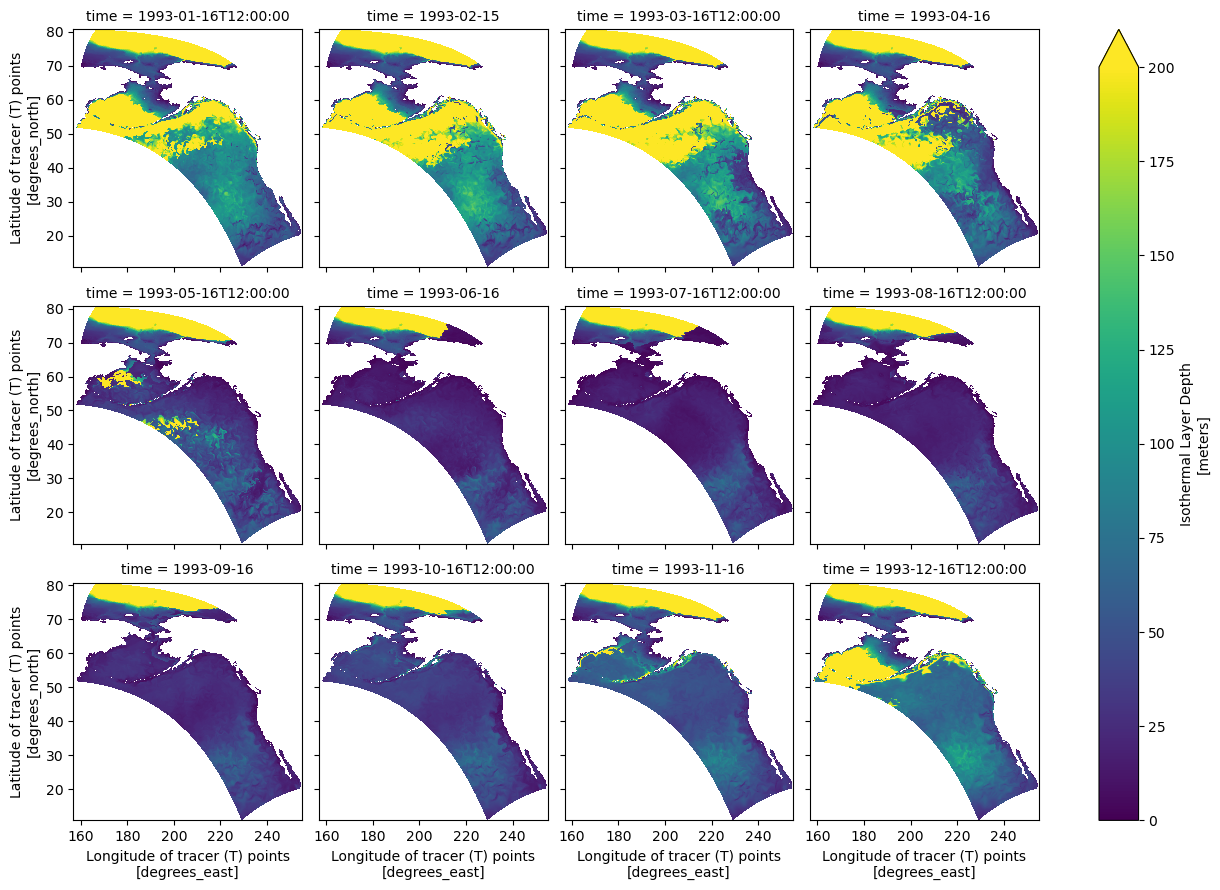

In [58]:
ds_ild_05['ild_05'].plot(x='geolon',y='geolat',vmin=0,vmax=200,col='time',col_wrap=4, cmap='viridis')

In [61]:
da_diff_t=(da_thetao.isel(z_l=0)-da_tos).compute()

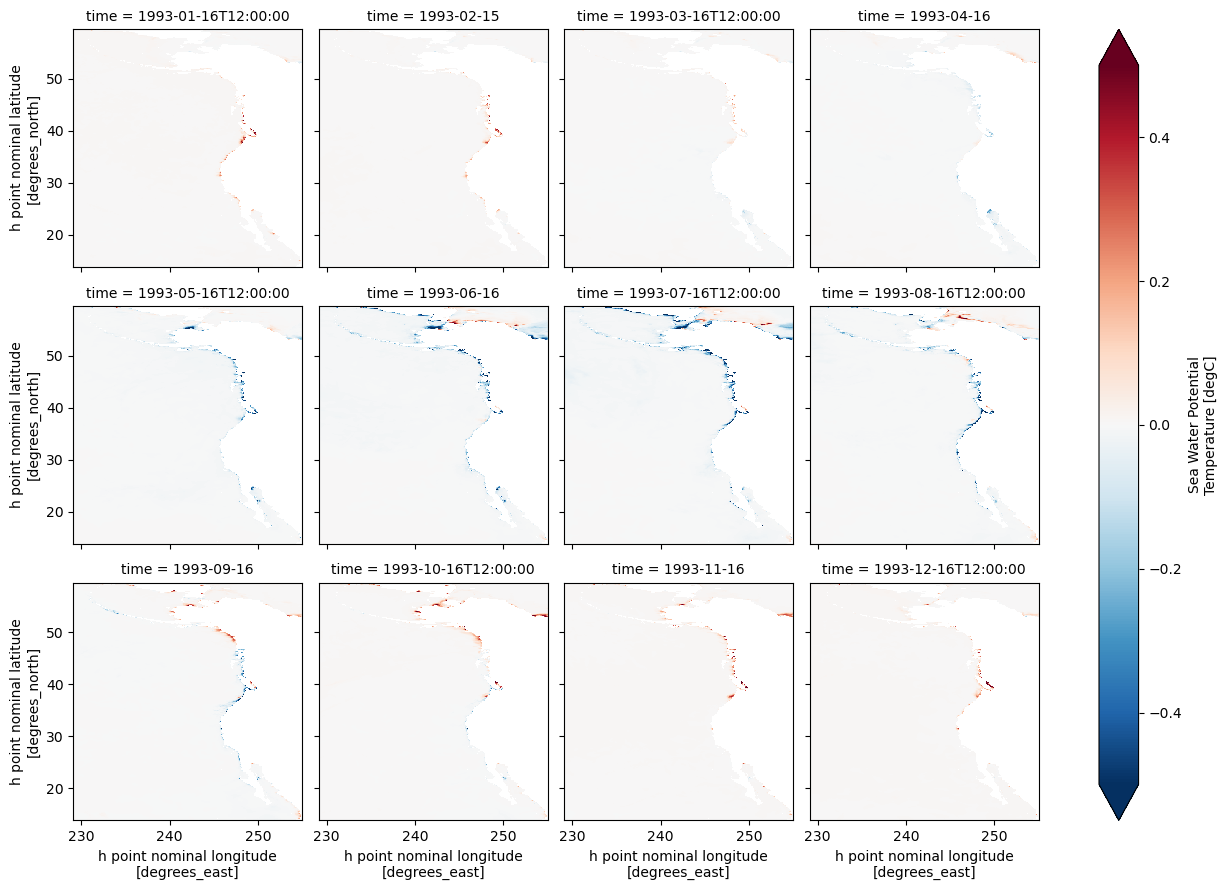

In [67]:
da_diff_t.plot(vmin=-0.5, vmax=0.5, col='time', col_wrap=4, cmap='RdBu_r')

In [1]:
from mom6.mom6_module.mom6_ild import IsothermalLayerDepth

In [2]:
dict_data_info = {
    "region": "northeast_pacific",
    "subdomain": "full_domain",
    "experiment_type": "hindcast",
    "output_frequency": "monthly",
    "grid_type": "raw",
    "release": "r20250509",
    "data_source": "local",
    "local_top_dir": "/Projects/CEFI/regional_mom6/"
}
from mom6.mom6_module.mom6_read import AccessFiles
cefi_data_access = AccessFiles(**dict_data_info)

In [3]:
tos_path = cefi_data_access.get(variable='tos')[0]
thetao_path = cefi_data_access.get(variable='thetao')[0]
depth_path = cefi_data_access.get(variable='ocean_static')[0]


In [4]:
import xarray as xr
da_tos = xr.open_dataset(tos_path,chunks={'time': 1, 'yh': 50, 'xh': 50})['tos'].isel(time=slice(0,12))
da_thetao = xr.open_dataset(thetao_path,chunks={'time': 1, 'yh': 50, 'xh': 50, 'z_l': -1})['thetao'].isel(time=slice(0,12))
da_depth = xr.open_dataset(depth_path,chunks={'time': 1, 'yh': 50, 'xh': 50})['deptho']

In [6]:
ild_obj = IsothermalLayerDepth(
    da_sst=da_tos,
    da_thetao=da_thetao,
    da_depth=da_thetao['z_l'],
    da_bottom_depth=da_depth,
    ild_temp_offset=0.5,
    depth_dim_name='z_l'
)


In [7]:
# more worker less threads due to GIL of the task involved
from dask.distributed import Client
client = Client(n_workers=80, threads_per_worker=1)
print(client.dashboard_link)
ds_ild = ild_obj.calculate_ild().compute()

http://127.0.0.1:33777/status


In [8]:
ds_ild = xr.merge([ds_ild, xr.open_dataset(depth_path)])
ds_ild = ds_ild.set_coords(['geolon', 'geolat'])
# due to missing value in the coordinate
ds_ild['geolon'] = ds_ild['geolon'].where(ds_ild['geolon'].notnull(), ds_ild['geolon'].min())
ds_ild['geolat'] = ds_ild['geolat'].where(ds_ild['geolat'].notnull(), ds_ild['geolat'].min())

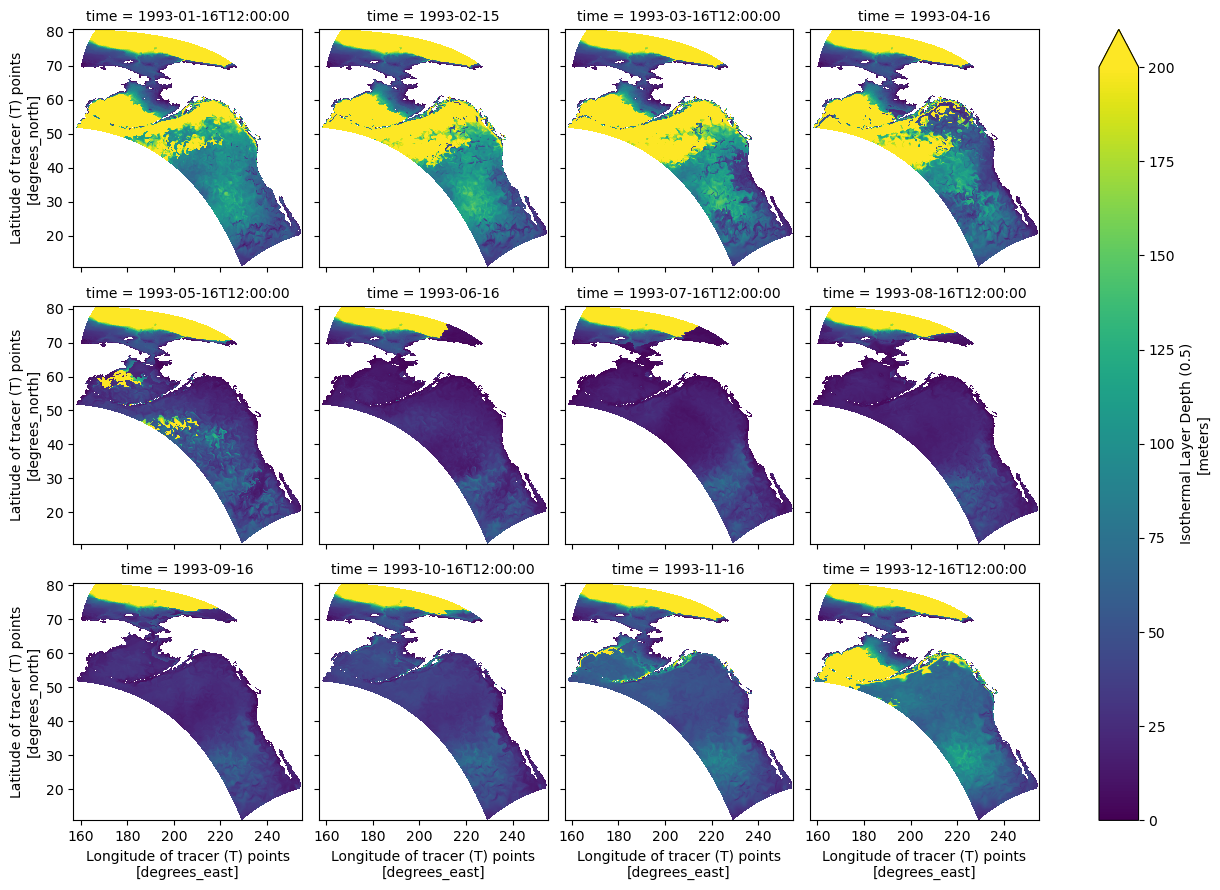

In [9]:
ds_ild['ild'].plot(x='geolon',y='geolat',vmin=0,vmax=200,col='time',col_wrap=4, cmap='viridis')